# Import Model

In [1]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.act1  = nn.SiLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.shortcut = None
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        self.act2 = nn.SiLU()

    def forward(self, x):
        identity = x
        out = self.act1(self.bn1(self.conv1(x)))
        out = self.act2(self.bn2(self.conv2(out)))
        if self.shortcut is not None:
            identity = self.shortcut(x)
        return out + identity



class DeepTileEncoder(nn.Module):
    """加深的 Tile 分支：全局信息，多尺度池化 + 三层 MLP"""
    def __init__(self, out_dim, in_channels=3, negative_slope=0.01):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.SiLU(),
            nn.MaxPool2d(2)  # 78→39
        )
        self.layer1 = nn.Sequential(
            ResidualBlock(32, 64),
            ResidualBlock(64, 64),
            nn.MaxPool2d(2)  # 39→19
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128),
            ResidualBlock(128, 128),
            nn.MaxPool2d(2)  # 19→9
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(128, 256),
            ResidualBlock(256, 256)
        )  # 保持 9×9

        # 多尺度池化
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # [B,256,1,1]
        self.mid_pool    = nn.AdaptiveAvgPool2d((3, 3))  # [B,256,3,3]

        total_dim = 256*1*1 + 256*3*3
        # 三层 MLP：total_dim → 2*out_dim → out_dim → out_dim
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.1),
            nn.Linear(total_dim, out_dim*4),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(out_dim*4, out_dim*2),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(out_dim*2, out_dim),
            nn.LeakyReLU(negative_slope),
        )

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # x: [B,256,9,9]
        g = self.global_pool(x).contiguous().reshape(x.size(0), -1)  # [B,256]
        m = self.mid_pool(x).contiguous().reshape(x.size(0), -1)     # [B,256*3*3]

        return self.fc(torch.cat([g, m], dim=1))


class SubtileEncoder(nn.Module):
    """多尺度 Subtile 分支：局部信息 + 两层 MLP"""
    def __init__(self, out_dim, in_channels=3, negative_slope=0.01):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.SiLU(),
            nn.MaxPool2d(2)  # 26→13
        )
        self.layer1 = nn.Sequential(
            ResidualBlock(32, 64),
            ResidualBlock(64, 64),
            nn.MaxPool2d(2)  # 13→6
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128),
            ResidualBlock(128, 128)
        )  # 保持 6×6

        self.global_pool = nn.AdaptiveAvgPool2d((1,1))
        self.mid_pool    = nn.AdaptiveAvgPool2d((2,2))
        self.large_pool    = nn.AdaptiveAvgPool2d((3,3))

        total_dim = 128*1*1 + 128*2*2 + 128*3*3
        # 两层 MLP：total_dim → out_dim*2 → out_dim
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.1),
            nn.Linear(total_dim, out_dim*2),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(out_dim*2, out_dim),
            nn.LeakyReLU(negative_slope),
        )

    def forward(self, x):
        B, N, C, H, W = x.shape
        x = x.contiguous().reshape(B*N, C, H, W)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        # g,m: [B*N, feat]
        g = self.global_pool(x).contiguous().reshape(B, N, -1)
        m = self.mid_pool(x).contiguous().reshape(B, N, -1)
        l = self.large_pool(x).contiguous().reshape(B, N, -1)

        # 合并 N 张 subtiles，再 FC
        feat = torch.cat([g, m, l], dim=2).mean(dim=1).contiguous()  # [B, total_dim]
        return self.fc(feat)
class CenterSubtileEncoder(nn.Module):
    """專門處理中心 subtile 的 Encoder"""
    def __init__(self, out_dim, in_channels=3, negative_slope= 0.01):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.SiLU(),
            nn.MaxPool2d(2)  # 26→13
        )
        self.layer1 = nn.Sequential(
            ResidualBlock(32, 64),
            ResidualBlock(64, 64),
            nn.MaxPool2d(2)  # 13→6
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128),
            ResidualBlock(128, 128)
        )  # 6×6

        # 多尺度池化
        self.global_pool = nn.AdaptiveAvgPool2d((1,1))
        self.mid_pool    = nn.AdaptiveAvgPool2d((2,2))
        self.large_pool    = nn.AdaptiveAvgPool2d((3,3))

        total_dim = 128*1*1 + 128*2*2 + 128*3*3
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.1),
            nn.Linear(total_dim, out_dim*2),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(out_dim*2, out_dim),
            nn.LeakyReLU(negative_slope),
        )

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        g = self.global_pool(x).contiguous().reshape(x.size(0), -1)
        m = self.mid_pool(x).contiguous().reshape(x.size(0), -1)
        l = self.large_pool(x).contiguous().reshape(x.size(0), -1)

        return self.fc(torch.cat([g, m, l], dim=1)).contiguous()



class VisionMLP_MultiTask(nn.Module):
    """整體多任務模型：融合 tile + subtile + center，使用動態權重融合"""
    def __init__(self, tile_dim=128, subtile_dim=64, output_dim=35, negative_slope=0.01):
        super().__init__()
        self.encoder_tile    = DeepTileEncoder(tile_dim)
        self.encoder_subtile = SubtileEncoder(subtile_dim)
        self.encoder_center  = CenterSubtileEncoder(subtile_dim)

        # 輸出 decoder：輸入為 tile_dim (因為融合後只剩一個 vector)
        self.decoder = nn.Sequential(
            nn.Linear(tile_dim + subtile_dim + subtile_dim , 256),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(64, output_dim),
        )

    def forward(self, tile, subtiles):
        tile = tile.contiguous()
        subtiles = subtiles.contiguous()
        center = subtiles[:, 4]

        f_tile = self.encoder_tile(tile)         # [B, tile_dim]
        f_sub  = self.encoder_subtile(subtiles)  # [B, subtile_dim]
        f_center = self.encoder_center(center)   # [B, subtile_dim]

        # 拼接三個分支做 gating
        features_cat = torch.cat([f_tile, f_sub, f_center], dim=1)  # [B, tile+sub+center]
        return self.decoder(features_cat)





# 用法示例
model = VisionMLP_MultiTask(tile_dim=128, subtile_dim=128, output_dim=35)


# —— 5) 确保只有 decoder 可训练 ——  
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total     = sum(p.numel() for p in model.parameters())
print(f"Trainable / total params = {trainable:,} / {total:,}")


Trainable / total params = 6,679,843 / 6,679,843


## Load Model

# Import training data

## Same in multiple .pt

In [5]:
import os
import torch
import random
import inspect
import os
os.chdir("/Users/deweywang/Desktop/GitHub/HEVisum/")
from scripts.import_data import load_all_tile_data

# 用法範例
folder = "dataset/try/train_data/"

grouped_data = load_all_tile_data( 
        folder_path=folder,
        model=model,
        fraction=1,
        shuffle=False
    )

    # grouped_data 現在只會有 model.forward() 需要的 key，
    # 像 ['tile','subtiles','neighbors','norm_coord','node_feat','adj_list','edge_feat','label','source_idx']
print("Loaded keys:", grouped_data.keys())
print("Samples:", len(next(iter(grouped_data.values()))))


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/deweywang/Desktop/GitHub/HEVisum/scripts/import_data.py:251: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals

Loaded keys: dict_keys(['source_idx', 'position', 'subtiles', 'label', 'slide_idx', 'tile'])
Samples: 8348


In [ ]:
import os
import torch
import csv
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from scripts.operate_model import train_one_epoch, evaluate, predict, plot_losses, plot_per_cell_metrics,spear_EarlyStopping
import torch.nn as nn

# ---------------------------
# Your save_folder path for the plots and model
# ---------------------------
save_folder = "output_folder/"  # 修改為你想要的資料夾名稱
if not os.path.exists(save_folder):   
    os.makedirs(save_folder)


In [8]:
# --------------------------------------------
# 2) 從 grouped_data 取出 slide_idx，轉成 numpy
# --------------------------------------------
import numpy as np
slide_idx = np.array(grouped_data['slide_idx'])   # shape (N,)

# --------------------------------------------
# 3) 建立 LOGO（或改成 GroupKFold）
# --------------------------------------------
from sklearn.model_selection import LeaveOneGroupOut
logo = LeaveOneGroupOut()

# X 可以給虛擬矩陣，因為分組只靠 groups
X_dummy = np.zeros(len(slide_idx))
X_dummy

array([0., 0., 0., ..., 0., 0., 0.])

EarlyStopping counter: 10/10
[Epoch 17]  lr=3.97e-04, train_loss=35.1967, val_loss=96.6681
train spearman: 0.8182 | Val spearman: 0.4213 | best: 0.6427


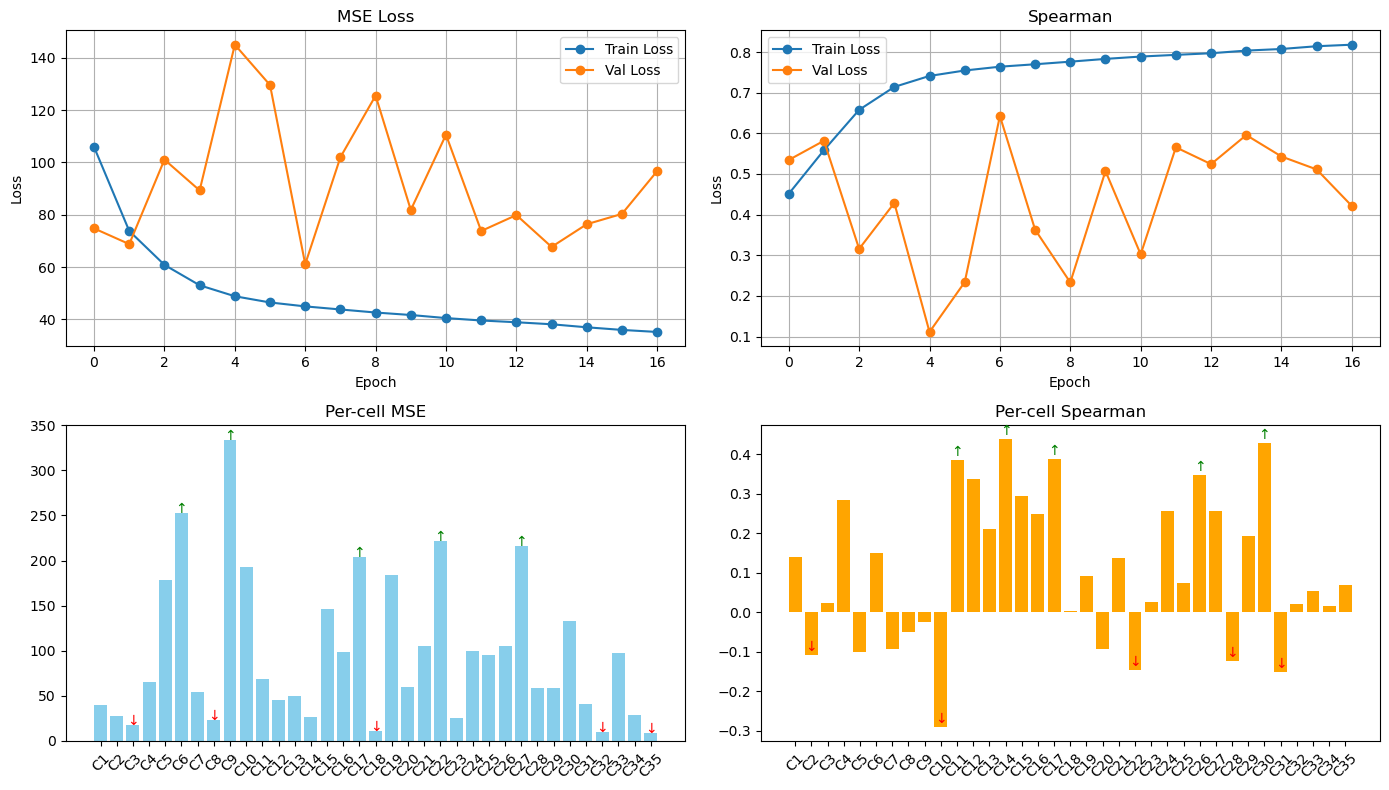

<Figure size 640x480 with 0 Axes>

save plots in output_folder/fold5/loss_curve.png
⛔ early stop
📈 Fold 5 best ρ = 0.6427

=========== CV summary ===========
fold 0: best ρ = 0.6839
fold 1: best ρ = 0.7111
fold 2: best ρ = 0.6570
fold 3: best ρ = 0.5886
fold 4: best ρ = 0.5408
fold 5: best ρ = 0.6427
overall best (mean) ρ = 0.6374 ± 0.0573


In [ ]:
from torch.utils.data import DataLoader
from scripts.import_data import importDataset
from scripts.aug         import augment_grouped_data, identity, subset_grouped_data
import math
from torch.optim.lr_scheduler import LambdaLR
# ---------------- 基本參數 ----------------
start_fold = 0   # 从第几个 fold 开始训练（0-based），小于此值的 fold 会跳过

BATCH_SIZE   = 32
num_epochs   = 150
repeats      = 0
# ---------------- 參數設定 ----------------
save_root    = save_folder          # 最外層
os.makedirs(save_root, exist_ok=True)

# Seed once at the very top for reproducibility

logo     = LeaveOneGroupOut()
device   = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("✅ device:", device)

overall_best = []
# 在你的脚本文件头部



# ➋ LOGO / GroupKFold 切分索引，對 Dataset 建 Subset
for fold_id, (tr_idx, va_idx) in enumerate(
        logo.split(X=np.zeros(len(slide_idx)), y=None, groups=slide_idx)):
    
        # 如果当前 fold < start_fold，就跳过
    if fold_id < start_fold:
        print(f"⏭️ Skipping fold {fold_id}")
        continue
    
    print("Starting fold", fold_id)
    print("Starting subseting...")

    train_base = subset_grouped_data(grouped_data, tr_idx)
    print("Starting augmenting...")

    train_ds = augment_grouped_data(
                    grouped_data=train_base,
                    image_keys=['tile','subtiles'],
                    repeats=repeats   # 比如对每张做 2 次增强
                )
    print("Starting importDataset...")
    # 1) 原始 dataset
    train_ds = importDataset(train_ds, model,
                            image_keys=['tile','subtiles'],
                            transform=identity)


    # 3) validation raw
    val_ds     = subset_grouped_data(grouped_data, va_idx)
    val_ds     = importDataset(val_ds, model,
                            image_keys=['tile','subtiles'],
                            transform=identity)

    print("Starting DataLoader...")
    # 4) DataLoader 不再動態增強
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=0, pin_memory=False)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE,
                              shuffle=False, num_workers=0, pin_memory=False)

    # 5) 一切其餘步驟同之前：定模型、optimizer、train_one_epoch、evaluate……

    print("Starting model...")
    # ----- 新建模型 / 優化器 -----
    net = VisionMLP_MultiTask(tile_dim=128, subtile_dim=128, output_dim=35)

    net = net.to(device)

    # 我们把原来 Adam 换成 AdamW，稍微加一点 weight decay
    peak_lr       = 1e-3
    min_lr        = 1e-6
    warmup_epochs = 0
    total_epochs  = 30

    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, net.parameters()),
        lr=peak_lr, weight_decay=1e-3
    )

    # 定义 lr_lambda
    def lr_lambda(cur_epoch):
        if cur_epoch < warmup_epochs:
            # 线性 warm-up: 从 0 → 1
            return float(cur_epoch + 1) / warmup_epochs
        else:
            # 余弦退火：从 1 → min_lr/peak_lr
            progress = (cur_epoch - warmup_epochs) / (total_epochs - warmup_epochs)
            # cos(0)=1 → cos(pi)=−1, remap to [min_ratio,1]
            min_ratio = min_lr / peak_lr
            return min_ratio + 0.5 * (1 - min_ratio) * (1 + math.cos(math.pi * progress))

    scheduler = LambdaLR(optimizer, lr_lambda)

    stopper = spear_EarlyStopping(patience=10)

    # ----- fold 專屬輸出路徑 -----
    fold_dir  = os.path.join(save_folder, f"fold{fold_id}")
    os.makedirs(fold_dir, exist_ok=True)
    best_model_path = os.path.join(fold_dir, "best_model.pt")
    loss_plot_path  = os.path.join(fold_dir, "loss_curve.png")
    csv_path        = os.path.join(fold_dir, "training_log.csv")

    # ----- CSV log -----
    log_f = open(csv_path, "w", newline="")
    csv_w = csv.writer(log_f)
    csv_w.writerow(["Epoch","TrainLoss","ValLoss","ValSpearman","LR"])

    # ----- 圖形 -----
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    display(fig)

    train_losses = []; val_losses = []
    train_rhos   = []; val_rhos   = []

    best_rho = -1.0
    print("Starting training...")
    for epoch in range(num_epochs):

        tloss, trho = train_one_epoch(
            net, train_loader, optimizer, device,
            current_epoch=epoch, initial_alpha=0, final_alpha=0, target_epoch=20 )

        vloss, vrho, mse_cell, rho_cell = evaluate(
            net, val_loader, device,
            current_epoch=epoch, initial_alpha=0, final_alpha=0, target_epoch=20 )

        clear_output(wait=True)  # 清除之前的輸出
        axes[0][0].clear()
        axes[0][1].clear()
        axes[1][0].clear()
        axes[1][1].clear()
        # --- save best ---
        if vrho > best_rho:
            best_rho = vrho
            torch.save(net.state_dict(), best_model_path)
            print(f"✅ Saved best model in {best_model_path}!")

        # --- scheduler / early stop ---
        scheduler.step()
        stopper(vrho)


    
        # --- logging ---
        lr = optimizer.param_groups[0]['lr']
        csv_w.writerow([epoch+1, tloss, vloss, vrho, lr])

        train_losses.append(tloss); val_losses.append(vloss)
        train_rhos.append(trho);   val_rhos.append(vrho)
        

        

        # 印出 Epoch 結果
        lr = optimizer.param_groups[0]['lr']
        print(f"[Epoch {epoch+1}]  lr={lr:.2e}, train_loss={tloss:.4f}, val_loss={vloss:.4f}")
        print(f"train spearman: {trho:.4f} | Val spearman: {vrho:.4f} | best: {best_rho:.4f}")
        # --- update plots ---
        plot_losses(train_losses, val_losses, axes[0][0], "MSE Loss")
        plot_losses(train_rhos,   val_rhos,   axes[0][1], "Spearman")
        cell_names = [f"C{i+1}" for i in range(35)]
        plot_per_cell_metrics(mse_cell, rho_cell, cell_names,
                              ax_mse=axes[1][0], ax_spearman=axes[1][1])
        plt.tight_layout(); display(fig); plt.pause(0.1)
        fig.savefig(loss_plot_path)
        print(f"save plots in {loss_plot_path}")
        if stopper.early_stop:
            print("⛔ early stop"); break

    log_f.close(); plt.close(fig)
    overall_best.append(best_rho) 
    print(f"📈 Fold {fold_id} best ρ = {best_rho:.4f}")

# ========= 整體結果 =========
overall_best = np.array(overall_best)
print("\n=========== CV summary ===========")
for i, r in enumerate(overall_best):
    print(f"fold {i}: best ρ = {r:.4f}")
print(f"overall best (mean) ρ = {overall_best.mean():.4f} ± {overall_best.std():.4f}")

# Predict

In [ ]:
import torch
import inspect
from scripts.operate_model import get_model_inputs
from scripts.import_data import load_node_feature_data


# 用法示例
from scripts.import_data import importDataset
# 假设你的 model 已经定义好并实例化为 `model`
test_dataset = load_node_feature_data("dataset/try/test/test_dataset.pt", model)
test_dataset = importDataset(
        data_dict=test_dataset,
        model=model,
        image_keys=['tile','subtiles'],
        transform=lambda x: x,  # identity transform
        print_sig=True
    )



/Users/deweywang/Desktop/GitHub/HEVisum/python_scripts/import_data.py:280: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw = torch.load(pt_path, map_location="cpu")


⚠️ 從 '<class 'list'>' 推斷樣本數量: 2088
Model forward signature: (tile, subtiles)


In [13]:
from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [19]:
import glob
import torch
import numpy as np
import pandas as pd
import os
import h5py
from torch.utils.data import DataLoader

# 讀 test spot index
with h5py.File("./dataset/elucidata_ai_challenge_data.h5","r") as f:
    test_spots     = f["spots/Test"]
    test_spot_table= pd.DataFrame(np.array(test_spots['S_7']))

fold_ckpts = sorted(glob.glob(os.path.join(save_folder, "fold*", "best_model.pt")))
models = []
for ckpt in fold_ckpts:
    net = VisionMLP_MultiTask(tile_dim=128, subtile_dim=128, output_dim=35)
    net = net.to(device)
    net.load_state_dict(torch.load(ckpt, map_location="cpu"))
    net.to(device).eval()
    models.append(net)

all_fold_preds = []
for fold_id, net in enumerate(models):
    # 推論
    with torch.no_grad():
        preds = predict(net, test_loader, device)  # (N_test,35) numpy array

    # 1) 存每一折的原始預測
    df_fold = pd.DataFrame(preds, columns=[f"C{i+1}" for i in range(preds.shape[1])])
    df_fold.insert(0, "ID", test_spot_table.index)
    path_fold = os.path.join(save_folder, f"submission_fold{fold_id}.csv")
    df_fold.to_csv(path_fold, index=False)
    print(f"✅ Saved fold {fold_id} predictions to {path_fold}")

    all_fold_preds.append(preds)

# 2) 做 rank‐average ensemble
all_fold_preds = np.stack(all_fold_preds, axis=0)       # (K, N_test, 35)
ranks          = all_fold_preds.argsort(axis=2).argsort(axis=2).astype(float)
mean_rank      = ranks.mean(axis=0)                    # (N_test,35)

# 3) 存 final ensemble
df_ens = pd.DataFrame(mean_rank, columns=[f"C{i+1}" for i in range(mean_rank.shape[1])])
df_ens.insert(0, "ID", test_spot_table.index)
path_ens = os.path.join(save_folder, "submission_rank_ensemble.csv")
df_ens.to_csv(path_ens, index=False)
print(f"✅ Saved rank‐ensemble submission to {path_ens}")


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_81643/1901899343.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(ckpt, map_loc

✅ Saved fold 0 predictions to output_folder/submission_fold0.csv
✅ Saved fold 1 predictions to output_folder/submission_fold1.csv
✅ Saved fold 2 predictions to output_folder/submission_fold2.csv
✅ Saved fold 3 predictions to output_folder/submission_fold3.csv
✅ Saved fold 4 predictions to output_folder/submission_fold4.csv
✅ Saved fold 5 predictions to output_folder/submission_fold5.csv
✅ Saved rank‐ensemble submission to output_folder/submission_rank_ensemble.csv


# 6 models stacking

In [20]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from scripts.import_data import importDataset  # 假设这个能给你 full_dataset
from scripts.aug import subset_grouped_data   # 用来切出 grouped_data
from torch.utils.data import DataLoader, Subset

# Settings
full_dataset = importDataset(grouped_data, model,
                             image_keys=['tile','subtiles'],
                             transform=lambda x: x)
trained_oof_model_folder = save_folder
n_folds    = 6
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
C          = 35  # 类别数 / 每个预测向量长度
META_EPOCHS = 250
tile_dim = 128
center_dim = 128
neighbor_dim = 128
# 1) Load full_dataset & y_true
n_samples = len(full_dataset)
y_true = np.vstack([full_dataset[i]['label'].cpu().numpy() for i in range(n_samples)])


In [ ]:
# 2) 对每个 fold 收集 OOF 预测
oof_preds = np.zeros((n_samples, n_folds, C), dtype=np.float32)
full_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=False)

for fold_id, (_, va_idx) in enumerate(
    logo.split(X=np.zeros(n_samples), y=None, groups=slide_idx)
):
    # a) load base model for this fold
    print(f"🍀 Fold {fold_id} predicting ...")
    ckpt = os.path.join(trained_oof_model_folder, f"fold{fold_id}", "best_model.pt")
    net  = VisionMLP_MultiTask(tile_dim, center_dim, output_dim=C).to(device)
    net.load_state_dict(torch.load(ckpt, map_location=device))
    net.eval()
    
    # b) 用这个 model 只对它的 **验证集** 做预测（OOF）
    val_ds = Subset(full_dataset, va_idx)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
    preds_list = []
    with torch.no_grad():
        for batch in full_loader:
            tiles, subtiles = batch['tile'].to(device), batch['subtiles'].to(device)
            center = subtiles[:,4]
            f_c = net.encoder_center(center)
            f_n = net.encoder_subtile(subtiles)
            f_t = net.encoder_tile(tiles)
            fuse = torch.cat([f_c,f_n,f_t], dim=1)
            out = net.decoder(fuse)
            preds_list.append(out.cpu().numpy())
    preds_fold = np.concatenate(preds_list, axis=0)  # (len(va_idx), C)

    # c) 填回到 oof_preds[:, fold_id, :]
    oof_preds[:, fold_id, :] = preds_fold

print("🍀 Preparing data for meta model ...")

# 3) reshape → stacking 特征矩阵 X_stack
X_stack = oof_preds.reshape(n_samples, n_folds*C)    # (N, n_folds*C)
y_stack = y_true                                   # (N, C)

# 4) 划分 meta‐train / meta‐val
X_train, X_val, y_train, y_val = train_test_split(
    X_stack, y_stack, test_size=0.2, random_state=42, shuffle=True
)

# 5) DataLoader
ds_train = TensorDataset(torch.from_numpy(X_train).float(),
                         torch.from_numpy(y_train).float())
ds_val   = TensorDataset(torch.from_numpy(X_val).float(),
                         torch.from_numpy(y_val).float())
loader_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
loader_val   = DataLoader(ds_val,   batch_size=BATCH_SIZE, shuffle=False)

# 6) 定义/初始化 stacking MLP
in_dim = n_folds * C
class StackingMLP(nn.Module):
    def __init__(self, in_dim, hidden_dims=[512,256], out_dim=35, dropout=0.2):
        super().__init__()
        layers = []
        prev = in_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.LeakyReLU(0.01))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.Dropout(dropout))
            prev = h
        # 最后一层直接输出 out_dim
        layers.append(nn.Linear(prev, out_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        """
        x: Tensor of shape [B, in_dim], in_dim = n_folds * C
        returns: Tensor of shape [B, out_dim]
        """
        return self.model(x)

mlp = StackingMLP(in_dim=n_folds*C, hidden_dims=[512,256], out_dim=C).to(device)

optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, min_lr=1e-6, verbose=True)
criterion = nn.MSELoss()

best_val = float('inf')
es_cnt, es_patience = 0, 20
best_path = os.path.join(trained_oof_model_folder, "stacking_meta_best.pt")

print("🍀 Start training meta model ...")

# 7) 训练循环
for epoch in range(1, META_EPOCHS+1):
    mlp.train()
    train_loss = 0.0
    for xb, yb in loader_train:
        xb, yb = xb.to(device), yb.to(device)
        out = mlp(xb)               # 前向
        loss = criterion(out, yb)   # MSE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(ds_train)

    # 验证
    mlp.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in loader_val:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += criterion(mlp(xb), yb).item() * xb.size(0)
    val_loss /= len(ds_val)


    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch} — Train MSE {train_loss:.6f}, Val MSE {val_loss:.6f}, lr {current_lr:.3e}")
    scheduler.step(val_loss)

    if val_loss < best_val:
        best_val = val_loss; es_cnt = 0
        torch.save(mlp.state_dict(), best_path)
        print(" ↳ New best saved.")
    else:
        es_cnt += 1
        if es_cnt >= es_patience:
            print(" 🛑 Early stopping.")
            break

# 8) 从最好模型 load 回来
mlp.load_state_dict(torch.load(best_path, map_location=device))
mlp.eval()


🍀 Fold 0 predicting ...


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_81643/1968516026.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(ckpt, map_loc

🍀 Fold 1 predicting ...
🍀 Fold 2 predicting ...
🍀 Fold 3 predicting ...


In [ ]:

# --- 测试阶段：stacking 特征 + 一次 mlp.forward() ---
# 对测试集每个 fold 做预测，拼 oof_preds_test (n_test, n_folds, C)，reshape → (n_test, n_folds*C)
oof_test = np.zeros((len(test_dataset), n_folds, C), dtype=np.float32)
for fold_id in range(n_folds):
    print(f"🍀 Fold {fold_id} predicting ...")
    # load each base model & predict on full test_dataset
    ckpt = os.path.join(trained_oof_model_folder, f"fold{fold_id}", "best_model.pt")
    net  = VisionMLP_MultiTask(tile_dim, center_dim, output_dim=C).to(device)
    net.load_state_dict(torch.load(ckpt, map_location=device))
    net.eval()

    loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    preds_list = []
    with torch.no_grad():
        for batch in loader:
            tiles, subtiles = batch['tile'].to(device), batch['subtiles'].to(device)
            center = subtiles[:,4]
            fuse = torch.cat([
                net.encoder_center(center),
                net.encoder_subtile(subtiles),
                net.encoder_tile(tiles)
            ], dim=1)
            preds_list.append(net.decoder(fuse).cpu().numpy())
    oof_test[:, fold_id, :] = np.concatenate(preds_list, axis=0)

print("🍀 Meta model predicting ...")
X_test_stack = oof_test.reshape(len(test_dataset), n_folds*C)
with torch.no_grad():
    X_test_t = torch.from_numpy(X_test_stack).float().to(device)
    final_test_preds = mlp(X_test_t).cpu().numpy()

# 9) 存 submission
with h5py.File("./dataset/elucidata_ai_challenge_data.h5","r") as f:
    ids = pd.DataFrame(np.array(f["spots/Test"]["S_7"])).index
sub = pd.DataFrame(final_test_preds, columns=[f"C{i+1}" for i in range(C)])
sub.insert(0, 'ID', ids)
sub.to_csv(os.path.join(trained_oof_model_folder, "submission_stacked_single_mlp.csv"), index=False)
print("✅ Done single‐MLP stacking submission.")

🍀 Fold 0 predicting ...


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_81643/3338310424.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(ckpt, map_loca

🍀 Fold 1 predicting ...
🍀 Fold 2 predicting ...
🍀 Fold 3 predicting ...
🍀 Fold 4 predicting ...
🍀 Fold 5 predicting ...
🍀 Meta model predicting ...
✅ Done single‐MLP stacking submission.
